In [4]:
import src.utils as utils
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns

In [2]:
df = utils.build_color_spa_dataset('data/plantvillage/plantvillage dataset')

## Análisis de enfermedades comunes entre especies

Realizaremos un análisis sobre enfermedades presentes en más de una especie para determinar si existen patrones que dificulten al modelo reconocer la misma enfermedad en diversas especies de plantas. O por el contrario, el modelo fácilmente podrá identificar una enfermedad independientemente de la hoja.

In [3]:
# Filtrar las filas donde haya alguna enfermedad (no sanas)
df_enfermas = df[df['Enfermedad'].notna() & (df['Enfermedad'].str.lower() != 'none') & (df['Enfermedad'] != 'Sano')]

# Agrupar por enfermedad y contar las especies únicas para cada una
enfermedades_por_especie = df_enfermas.groupby('Enfermedad')['Especie'].nunique()

# Filtrar aquellas enfermedades que aparecen en más de una especie
enfermedades_comunes = enfermedades_por_especie[enfermedades_por_especie > 1].reset_index()

print("Enfermedades que afectan a más de una especie de planta:")
print(enfermedades_comunes)


Enfermedades que afectan a más de una especie de planta:
                            Enfermedad  Especie
0                    Mancha bacteriana        3
1  Oídio (cenicilla o polvillo blanco)        2
2                    Podredumbre negra        2
3                         Tizón tardío        2
4                       Tizón temprano        2


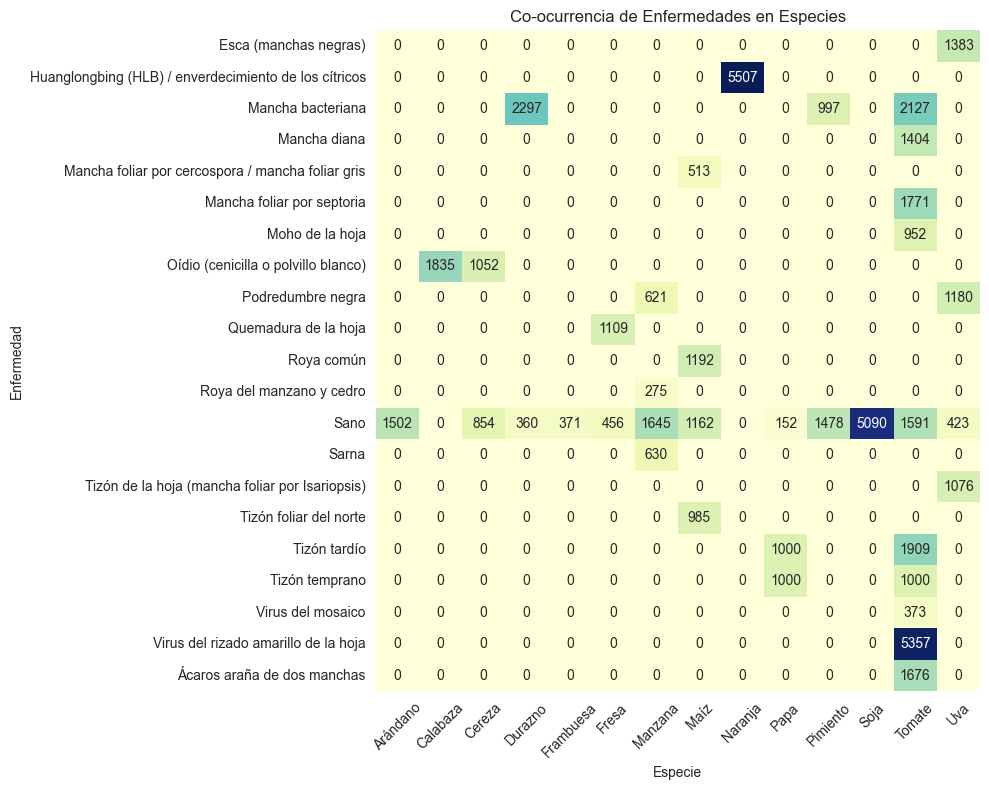

In [5]:
df_disease = df[df['Enfermedad'].notna()]

heatmap_data = pd.crosstab(df_disease['Enfermedad'], df_disease['Especie'])

heatmap_data = heatmap_data[heatmap_data.sum(axis=1) > 1]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Co-ocurrencia de Enfermedades en Especies")
plt.xlabel("Especie")
plt.ylabel("Enfermedad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Vemos que solo hay 5 enfermedades presentes en más de una especie de planta. Utilizaremos la enfermedad Mancha bacteriana como un ejemplo para comparar hojas enfermedas entre especies

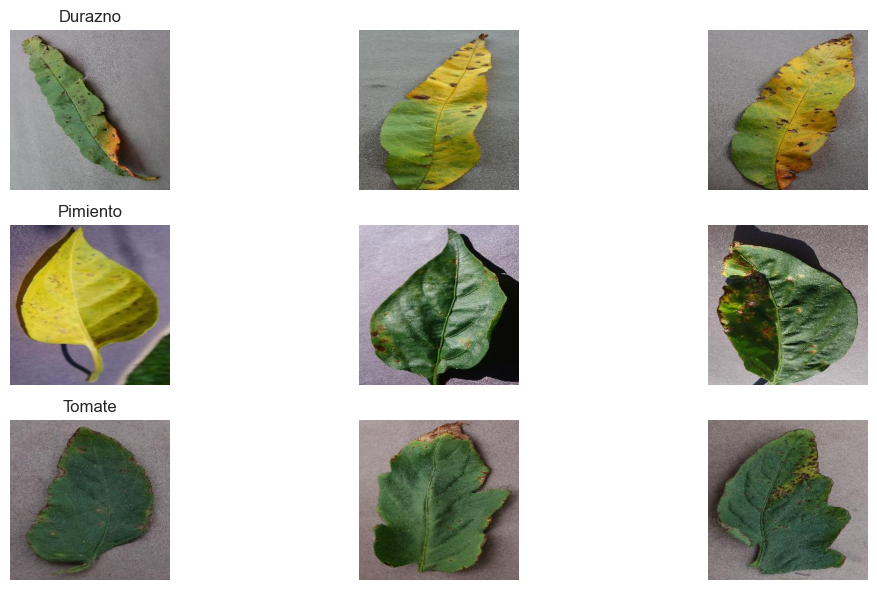

In [9]:
enfermedad = "Mancha bacteriana"
especies = ["Durazno", "Pimiento", "Tomate"]

bacterial_spot = df[(df['Enfermedad'] == enfermedad) & (df['Especie'].isin(especies))]

fig, axes = plt.subplots(len(especies), 3, figsize=(12, 6))

for i, especie in enumerate(especies):
    subset = bacterial_spot[bacterial_spot['Especie'] == especie]

    if subset.empty:
        for j in range(3):
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"{especie} (sin datos)")
        continue

    sample_count = min(3, len(subset))
    sampled_rows = subset.sample(sample_count)

    for j in range(3):
        axes[i, j].axis('off')

        if j < sample_count:
            row = sampled_rows.iloc[j]
            img = Image.open(row['File'])
            axes[i, j].imshow(img)

    axes[i, 0].set_title(especie)

plt.tight_layout()
plt.show()

A simple vista parece haber signos comunes en la enfermedad a pesar de que las hojas son distintas

Para profundizar el análisis usaremos un modelo HOG para describir la forma y textura de objetos dentro de una imagen de la hoja de las plantas. Luego extraeremos los vectores de las características de cada imágen y las representaremos en un plano utilizando PSA. Eso nos dará una idea gráfica de que tanta semejanza existe entre distintas especies con la misma enfermedad. 

100%|██████████| 15018/15018 [00:55<00:00, 272.27it/s]


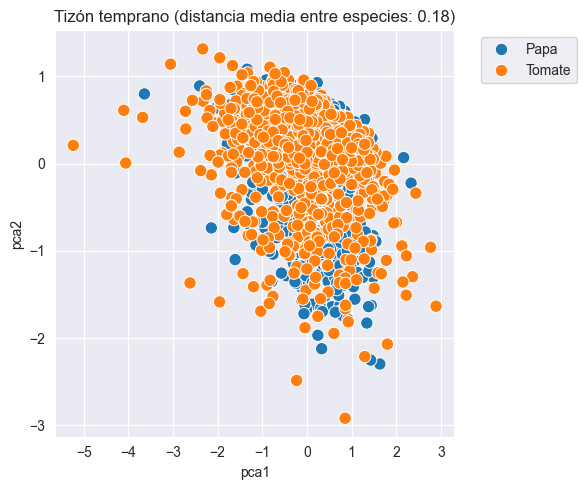

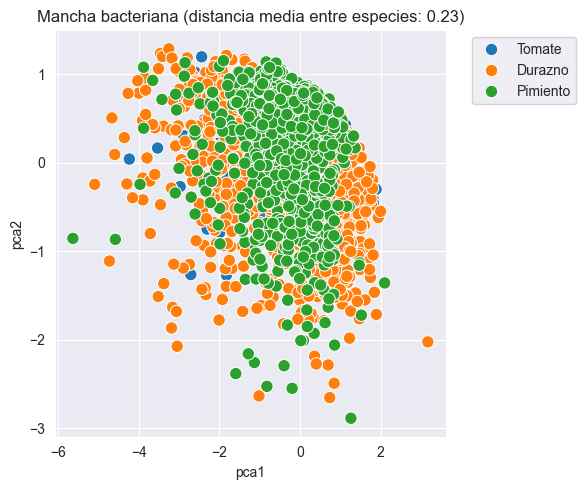

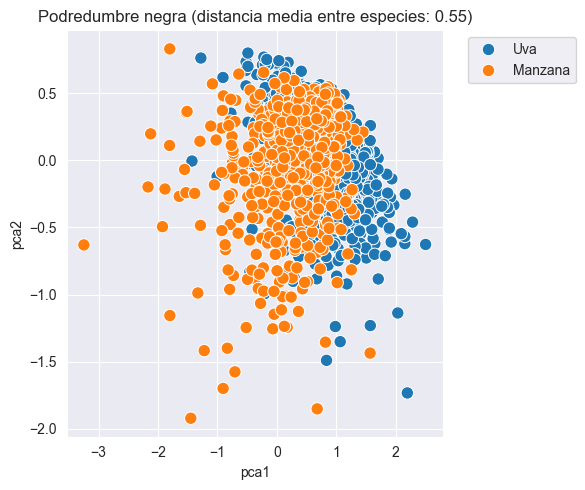

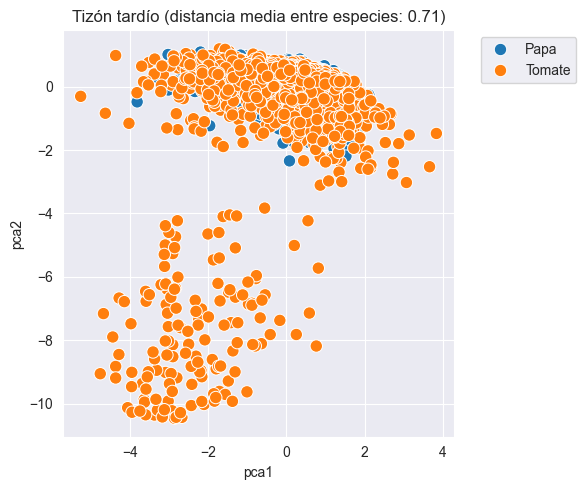

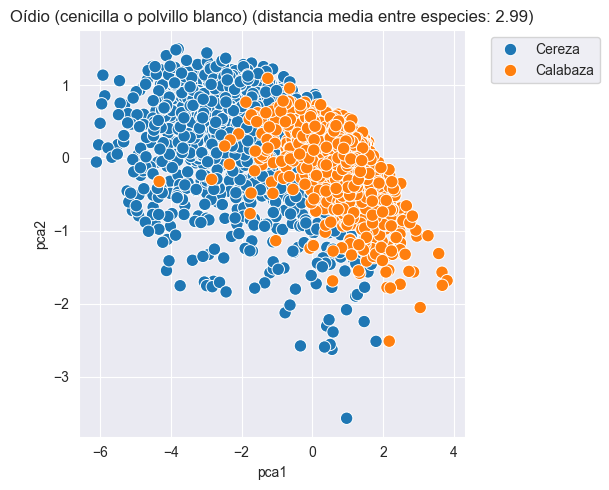

In [11]:
df_filtrado = df[df["Enfermedad"].isin(enfermedades_comunes['Enfermedad'])]
utils.plt_distance_species_with_same_disease(df_filtrado)

Haremos lo mismo con las hojas sanas entre especies para entender cuál es la semejanza entre las especies en su estado natural (o sano) para utilizarlo de parámetro de distancia cuando están enfermas. En este caso representaremos utilizando una matriz de confusión.

100%|██████████| 15084/15084 [00:56<00:00, 266.18it/s]


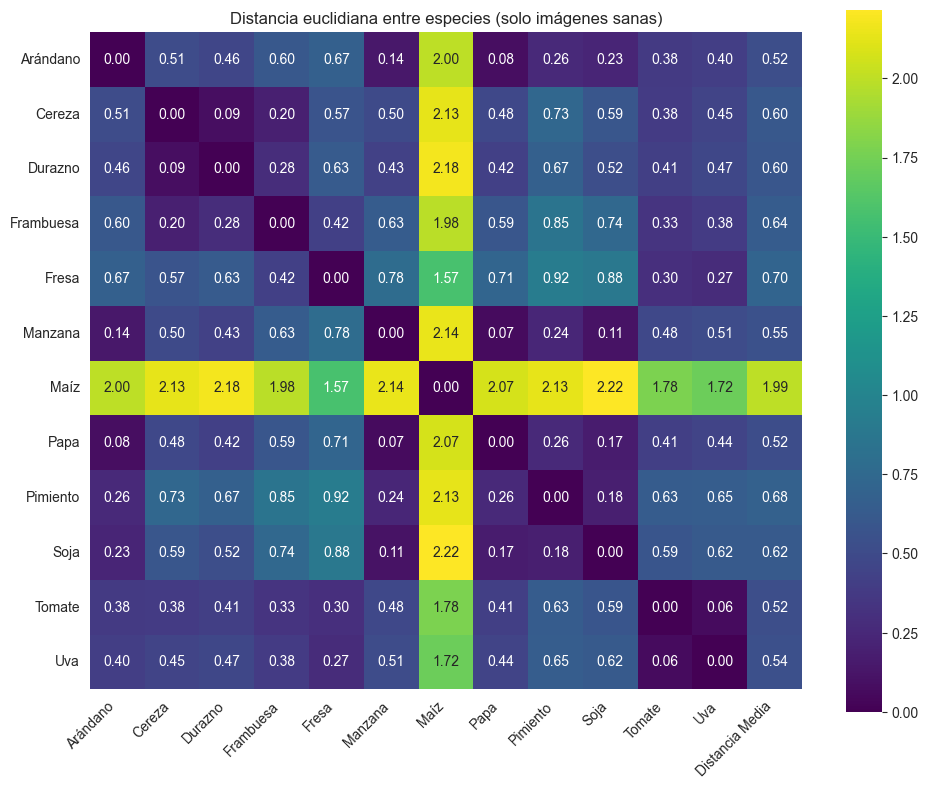

In [12]:
utils.plt_distance_healthy_species(df)

## Conclusiones – Análisis de enfermedades comunes entre especies

1. Distancias pequeñas entre especies para una misma enfermedad
En varios gráficos PCA de enfermedades (como Tizón temprano o Mancha bacteriana), vemos una alta superposición entre especies afectadas, y las distancias promedio entre especies son bajas (0.18 y 0.23, respectivamente).
Esto sugiere que la enfermedad produce efectos visuales similares en las hojas, sin importar la especie. En términos de features extraídas, los patrones se asemejan.

2. Distancias entre especies sanas
En la matriz de distancias de imágenes sanas, algunas especies tienen una distancia euclidiana promedio menor entre sí (por ejemplo: Tomate–Papa ≈ 0.41). Es decir, la distancia de las hojas sanas es menor a las enfermas pero por poca distancia. Esto podría indicarnos que la enfermedad por lo menos para estas especies no genera un cambio significativo en la hoja a tal punto de ser dificil de reconocer.  

3. Enfermedades con distancias grandes entre especies
Oídio (2.99) tiene la mayor distiancia de superposición. Es dificil de saber si esta distancia crece o decrece al estar enfermas cuando se comparan las hojas ya que no poseemos ejemplos de hojas sanas de Calabaza

Podemos decir que en general varias enfermedades comunes tienden a manifestarse visualmente de forma parecida entre diferentes especies, al menos desde la perspectiva de las features que estás utilizando (probablemente CNN embeddings).